In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from HyperNet import CustomHyperNet, CustomHyperConvLayer
from MNISTModel import MNISTHyperNetModel, StandardCNNModel

# HYPERNETWORK

### INTRODUCTIOIN

Hipernety lub w skrócie hipernety to Sieci neuronowe, które generują wagi dla innej sieci neuronowej, znanej jako sieć docelowa.
(Pojawiły się jako potężna technika głębokiego uczenia, która pozwala na większą elastyczność, zdolność adaptacji, dynamikę, szybsze szkolenie, wymianę informacji i kompresję modelu itp.)

(Deep learning (DL) zrewolucjonizował dziedzinę sztucznej inteligencji umożliwiając niezwykłe postępy w różnych dzidzinach, w tym wizja komputerowa, przetwarzanie języka naturalnego, wnioskowanie przyczynowe, i reinforcement learningu itp.)


(Jednak pomimo ich sukcesu standardowe DNN pozostają restrykcyjne w pewnych warunkach. Na przykład, gdy DNN jest pzetrenowany, jego wagi, a także architektura są stałe i wszelkie zmiany w wagach lub architekturze wymagają ponownego przetrenowania DNN) 


(Ten brak zdolności adaptacyjnych i dynamizmu ogranicza elastyczność
DNN, co czyni je mniej odpowiednimi do scenariuszy, w których wymagane są dynamiczne korekty lub adaptacja danych)



(Hypernetworks pojawiły się jako obiecujący paradygmat architektoniczny w celu zwiększenia elastyczności poprzez adaptacyjność danych i architektury dynamicznie oraz wydajność DNN. Hipernety to klasa sieci neuronowych
które generują wagi innej sieci neuronowej zwanej siecią docelową/główną/podstawową, gdzie zarówno sieci są szkolone w sposób end-to-end)

Kluczowe cechy i zalety hipernetów, które oferują aplikacje w różnych ustawieniach problemów:

* Soft weight sharing: Hipernetworks można trenować do generowania wag wielu DNN do rozwiązywania powiązanych zadań. Nazywa się to soft weight sharing, ponieważ w przeciwieństwie do hard weight sharing, który obejmuje wspólne warstwy między zadaniami (np. w multitasking), tutaj różne DNN są generowane przez wspólną hipernetę poprzez warunkowanie zadań. Jest to pomocne przy dzieleniu się informacjami między zadaniami i może być wykorzystywane do uczenia się transferowego lub dynamicznego udostępniania informacji.


* Dynamic architectures: Hipernetworks mogą być używane do generowania wag sieci o architekturze dynamicznej, w której liczba warstw lub struktura sieci zmienia się podczas szkolenia lub wnioskowania. Może to być szczególnie przydatne w przypadku zadań, w których docelowa struktura sieci nie jest znana w czasie szkolenia.


* Data-adaptive DNN: w przeciwieństwie do standardowego DNN, którego wagi są ustalane w czasie wnioskowania, HyperDNN można opracować w celu generowania sieci docelowej dostosowanej do potrzeb danych. W takich przypadkach hipernety są uwarunkowane danymi wejściowymi w celu dostosowania się do danych.


* Uncertainty quantification: Hipernety mogą skutecznie trenować DNN ktore świadome o niepewności, wykorzystując techniki jak multiple inputs z rozkładu szumów lub włączenie przerywania w hipernetach sami. Generując wiele zestawów wag dla sieci głównej, hipernety tworzą zespół modeli, każdy z różnymi konfiguracjami parametrów. To podejście oparte na zespole pomaga w szacowaniu niepewność w przewidywaniach modelu, kluczowy aspekt dla zastosowań krytycznych dla bezpieczeństwa, takich jak opieka zdrowotna, gdzie niezbędna jest miara zaufania do prognoz


* Parameter efficiency: DNN przeszkolony w hipernetach może mieć mniej wag niż
standardowe DNNs, powodujące z kompresji wag. Może to być szczególnie przydatne, gdy
cos diziala z ograniczonymi zasobami, ograniczonymi danymi lub w przypadku danych o dużych wymiarach i może skutkować szybszy trening niż zlykle DNN.

### ARCHITECTURE

#### Main Network

Struktura i rola: Main Network to typowa sieć neuronowa, którą można zaprojektować do dowolnego zadania głębokiego uczenia, takiego jak klasyfikacja obrazu, przetwarzanie języka naturalnego lub inne zadania. Struktura tej sieci może się różnić w zależności od konkretnego zadania: może to być splotowa sieć neuronowa (CNN) do przetwarzania obrazu, powtarzająca się sieć neuronowa (RNN) do przetwarzania sekwencji danych i tak dalej.

Uczenie: w normalnej sytuacji wagi tej sieci są inicjowane losowo, a następnie optymalizowane w procesie uczenia się, aby rozwiązać dany problem.

#### Hypernetwork

Struktura i rola: Hypernetwork to oddzielna sieć neuronowa, której celem jest generowanie wag dla sieci głównej. Ta sieć jest zwykle mniejsza i może być zaprojektowana tak, aby uwzględniać pewne cechy zadania, do którego szkolona jest sieć główna.

Interakcja z siecią główną: Hypernetwork pobiera dane wejściowe, które mogą zawierać informacje o stanie lub strukturze sieci głównej i na podstawie tych danych generuje wagi dla sieci głównej. Oznacza to, że wagi głównej sieci nie są bezpośrednio optymalizowane za pomocą standardowych metod szkoleniowych, takich jak propagacja wsteczna błędu, ale są generowane i zmieniane dynamicznie dzięki Hypernetwork.

In [2]:
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {train_accuracy:.2f}%')
    return train_loss, train_accuracy


In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)\n')
    return test_loss, test_accuracy


0.3%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




19.9%

100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Train Epoch: 1 	Loss: 0.006819 	Accuracy: 89.51%

Test set: Average loss: 0.1267, Accuracy: 9580/10000 (95.80%)

Train Epoch: 1 	Loss: 0.002614 	Accuracy: 94.99%

Test set: Average loss: 0.0562, Accuracy: 9825/10000 (98.25%)

Train Epoch: 2 	Loss: 0.001803 	Accuracy: 96.48%

Test set: Average loss: 0.0851, Accuracy: 9734/10000 (97.34%)

Train Epoch: 2 	Loss: 0.000841 	Accuracy: 98.32%

Test set: Average loss: 0.0426, Accuracy: 9868/10000 (98.68%)

Train Epoch: 3 	Loss: 0.001353 	Accuracy: 97.30%

Test set: Average loss: 0.0786, Accuracy: 9759/10000 (97.59%)

Train Epoch: 3 	Loss: 0.000641 	Accuracy: 98.70%

Test set: Average loss: 0.0433, Accuracy: 9853/10000 (98.53%)

Train Epoch: 4 	Loss: 0.001114 	Accuracy: 97.88%

Test set: Average loss: 0.0704, Accuracy: 9771/10000 (97.71%)

Train Epoch: 4 	Loss: 0.000508 	Accuracy: 98.97%

Test set: Average loss: 0.0359, Accuracy: 9885/10000 (98.85%)

Train Epoch: 5 	Loss:

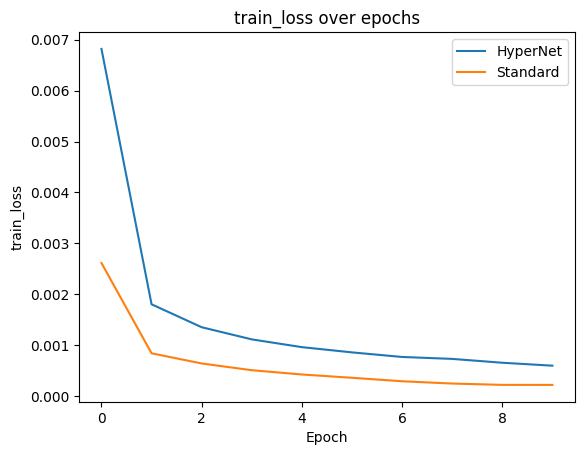

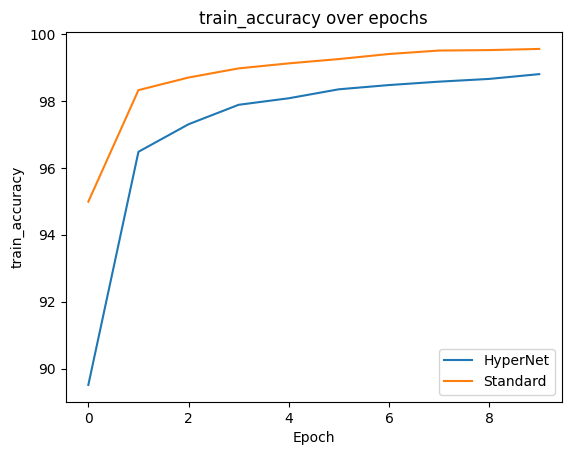

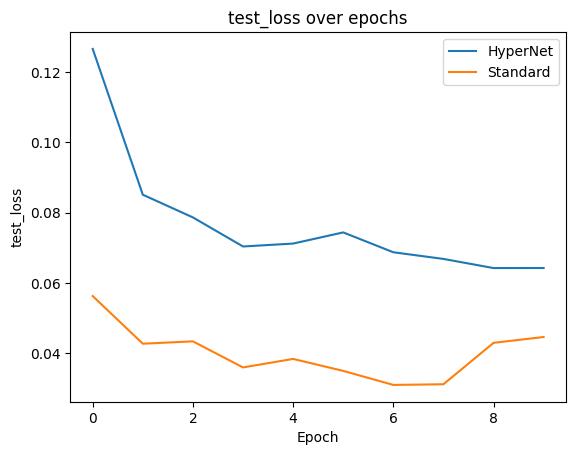

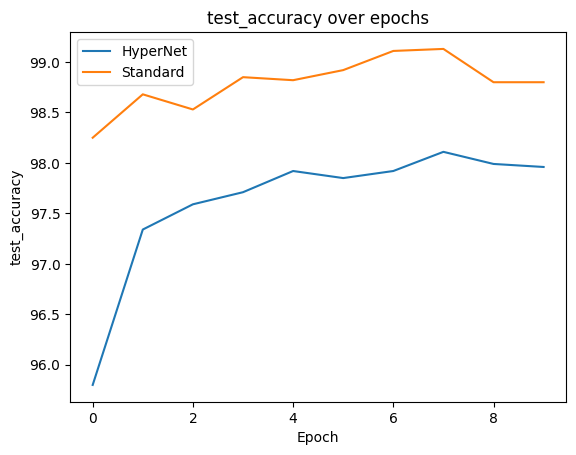

In [5]:
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hyper = MNISTHyperNetModel().to(device)
optimizer_hyper = optim.Adam(model_hyper.parameters(), lr=0.001)

model_standard = StandardCNNModel().to(device)  
optimizer_standard = optim.Adam(model_standard.parameters(), lr=0.001)

train_loader, test_loader = load_data()

results = {"hyper": {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []},
           "standard": {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}}

for epoch in range(1, 11):
    train_loss, train_accuracy = train(model_hyper, device, train_loader, optimizer_hyper, epoch)
    test_loss, test_accuracy = test(model_hyper, device, test_loader)
    results["hyper"]["train_loss"].append(train_loss)
    results["hyper"]["train_accuracy"].append(train_accuracy)
    results["hyper"]["test_loss"].append(test_loss)
    results["hyper"]["test_accuracy"].append(test_accuracy)

    train_loss, train_accuracy = train(model_standard, device, train_loader, optimizer_standard, epoch)
    test_loss, test_accuracy = test(model_standard, device, test_loader)
    results["standard"]["train_loss"].append(train_loss)
    results["standard"]["train_accuracy"].append(train_accuracy)
    results["standard"]["test_loss"].append(test_loss)
    results["standard"]["test_accuracy"].append(test_accuracy)

def plot_results(results, metric):
    plt.plot(results["hyper"][metric], label="HyperNet")
    plt.plot(results["standard"][metric], label="Standard")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{metric} over epochs")
    plt.legend()
    plt.show()

plot_results(results, "train_loss")
plot_results(results, "train_accuracy")
plot_results(results, "test_loss")
plot_results(results, "test_accuracy")



## Categorisation of Hypernetworks

Существует разделение на 5 критериев дезайна гиперсетей
- input-based 
- output-based
- variability of inputs 
- variability of outputs
- architecture-based

с помощью каждого из них можно можно подробнее понять работы конкретной гиперсети отвечая на вопросы:

![categorisation.png](./imgs/categorisation.png)

### Input-based hypernetworks

Hypernetworkш przyjmują wektor kontekstowy jako dane wejściowe i generują wagi docelowej sieci DNN jako wyjście. W zależności od użytego wektora kontekstowego możemy wyróżnić następujące typy hypernetworks:


- **Task-conditioned hypernetworks**: Te sieci przyjmują informacje specyficzne dla zadania jako dane wejściowe, takie jak tożsamość zadania, hiperparametry, architektury lub inne wskazówki specyficzne dla zadania. Sieć generuje wagi dostosowane do konkretnego zadania, co pozwala na dostosowanie jej zachowania i współdzielenie informacji między zadaniami, co skutkuje lepszą wydajnością.


- **Data-conditioned hypernetworks**: Te sieci są warunkowane danymi, na których szkolona jest docelowa sieć. Sieć generuje wagi na podstawie charakterystyki danych wejściowych, co pozwala na dynamiczną adaptację modelu do konkretnych wzorców lub cech, prowadząc do większej elastyczności i lepszej generalizacji.


- **Noise-conditioned hypernetworks**: Te sieci nie są warunkowane żadnymi danymi wejściowymi ani wskazówkami zadania, a raczej losowo wybranym szumem. Sprawia to, że są bardziej uniwersalne i pomagają w kwantyfikacji niepewności predykcyjnej dla DNN, ale mogą nie osiągać tak dobrych wyników jak sieci warunkowane zadaniem lub danymi na wielu zadaniach lub zbiorach danych.

### Output-based Hypernetworks

W zależności od sposobu generowania wag, czyli strategii generacji wag, klasyfikujemy hypernetworki na te, które generują wszystkie wagi naraz, i te, które tego nie robią. Klasyfikacja ta jest ważna, ponieważ kontroluje skalowalność i złożoność hypernetworks, ponieważ typowe DNN mają dużą liczbę wag, a ich jednoczesna produkcja może powiększyć rozmiar ostatniej warstwy hypernetworki.

- **Generate Once**: Te sieci generują wagi całej docelowej sieci DNN naraz. Wszystkie wygenerowane wagi są używane, a wagi każdej warstwy są generowane razem, w przeciwieństwie do innych strategii generowania wag. Jednakże, ta metoda generowania wag nie jest odpowiednia dla dużych sieci docelowych, ponieważ może to prowadzić do skomplikowanych hypernetwork.

- **Generate Multiple**: Te sieci mają wiele głów????? do produkcji wag (czasami nazywane jako split/multi-head hypernetwork) i ta metoda generowania wag może uzupełniać inne podejścia. Upraszcza to złożoność i redukuje liczbę wag wymaganych w ostatniej warstwie hypernetwork przez liczbę głów. Ta metoda nie wymaga dodatkowych osadzeń i ogólnie używa wszystkich wygenerowanych wag, w przeciwieństwie do podejść generowania wag component-wise i chunk-wise, gdzie niektóre wagi pozostają nieużywane.


- **Generate Chunk-wise**: Sieci tego typu generują wagi docelowej sieci w częściach. Może to prowadzić do niewykorzystania niektórych wygenerowanych wag, ponieważ są one produkowane zgodnie z rozmiarem części, który może nie odpowiadać rozmiarom warstw. Jeśli rozmiar części jest mniejszy niż warstwa, wagi dla całej warstwy mogą nie być generowane jednocześnie. Ponadto, te sieci wymagają dodatkowych osadzeń do rozróżniania różnych części i generowania specyficznych wag dla nich. Jednak ogólnie generowanie wag w częściach prowadzi do zmniejszenia złożoności i poprawy skalowalności sieci.

- **Generate Component-wise**: Strategia generowania wag składowych polega na oddzielnym tworzeniu wag dla każdego indywidualnego komponentu (takiego jak warstwa lub kanał) modelu docelowego. Jest to pomocne w generowaniu specyficznych wag, ponieważ różne warstwy lub kanały reprezentują różne cechy lub wzorce w sieci. Jednak podobnie jak w podejściu kawałkowym, sieci hypernetwork składowe wymagają osadzenia dla każdego komponentu, aby odróżnić różne komponenty i wytworzyć wagi specyficzne dla danego komponentu. Pomaga to również zmniejszyć złożoność i poprawić skalowalność sieci hypernetwork. Ponieważ wagi są generowane zgodnie z rozmiarem największej warstwy, ten sposób generowania wag może prowadzić do niewykorzystania niektórych wag w mniejszych warstwach. Ta strategia może być postrzegana jako specjalny przypadek podejścia kawałkowego do generowania wag, gdzie jeden kawałek odpowiada rozmiarowi jednego komponentu.




### Variability of Inputs

We can categorize hypernets based on the variability of the inputs. We have two classes, static inputs and dynamic
inputs, as discussed below.

- Static Inputs: Jeśli Dane wejściowe są predefiniowane i są stałe, hypernet jest nazywany statycznym w odniesieniu do danych wejściowych. Za
przykład wielozadaniowość [42] ma stałą liczbę zadań prowadzących do stałej liczby wejść. Należy zauważyć, że tutaj Naprawiono
dane wejściowe oznaczają tylko stałe tożsamości zadań, jednak hipernety mogą uczyć się osadzania dla różnych zadań.


- Dynamic Inputs: Jeśli Dane wejściowe zmieniają się i generalnie zależą od danych, na których trenowana jest sieć docelowa, następnie hypernet jest nazywany dynamicznym w odniesieniu do danych wejściowych. Dynamiczne wejścia pomagają hypernetworks wprowadzić nowy
poziom zdolności adaptacyjnych poprzez dynamiczne generowanie wag sieci docelowej. To dynamiczne generowanie masy
umożliwia hipernetworkom reagowanie na kontekst zależny od danych wejściowych i odpowiednie dostosowanie ich zachowania. Generując
wagi sieciowe w oparciu o określone dane wejściowe, hipernetworks może przechwytywać skomplikowane wzorce i zależności, które mogą się różnić
w różnych instancjach danych. Ta zdolność adaptacji prowadzi do zwiększenia wydajności modelu, szczególnie w scenariuszach z
złożone i ewoluujące dystrybucje danych



### Variability of Outputs

Klasyfikując sieci hypernetwork na podstawie charakterystyki wag sieci docelowej, możemy podzielić je na dwa typy: statyczne i dynamiczne wyjścia.


- **Static Outputs**: Jeśli wagi sieci docelowej mają stały rozmiar, to sieć hypernetwork nazywana jest statyczną względem wyjść. W takim przypadku sieć docelowa również jest statyczna.


- **Dynamic Outputs**: Jeśli wagi sieci docelowej nie są stałe, architektura zmienia się w zależności od rozmiaru, to sieć hypernetworku nazywana jest dynamiczną względem wyjść, a sieć docelowa również jest siecią dynamiczną, ponieważ może mieć różną architekturę w zależności od wejścia sieci hypernetwork.

### Dynamism in Hypernetworks

- **Static Hypernets**: Jeśli wejście sieci hypernetwork jest stałe, tj. z góry określone, a liczba wag generowanych przez sieć hypernetwork dla sieci docelowej jest stała, tj. architektura jest stała, wówczas sieć hypernetwork nazywana jest statyczną. Takie sieci pracują z z góry określonymi wejściami, np. tożsamościami zadań, które mogą być uczone jako osadzenia, ale rozwiązywane zadania pozostają te same.



- **Dynamic Hypernets**: Jeśli wejście sieci hypernetwork opiera się na danych wejściowych sieci docelowej, tj. danych wejściowych, lub liczba wag generowanych przez sieć hypernetwork dla sieci docelowej jest zmienna, tj. architektura jest dynamiczna, wówczas sieć hypernetwork nazywana jest dynamiczną. Dynamiczne sieci hypernetwork są bardziej elastyczne i mogą dostosowywać swoje działanie i strukturę w odpowiedzi na zmieniające się warunki lub wymagania.

### Architecture of Hypernetworks

W klasyfikacji sieci hypernetwork na podstawie ich architektury możemy wyróżnić cztery główne typy: wielowarstwowe perceptrony (MLP), konwolucyjne sieci neuronowe (CNN), rekurencyjne sieci neuronowe (RNN) oraz sieci oparte na mechanizmach uwagi.

- **MLPs**: Sieci hypernetwork oparte na MLP wykorzystują gęstą i w pełni połączoną architekturę, co pozwala na kompleksowe generowanie wag, biorąc pod uwagę całą informację wejściową.


- **CNNs**: Sieci hypernetwork oparte na CNN wykorzystują warstwy konwolucyjne do przechwytywania lokalnych wzorców i informacji przestrzennych, co sprawia, że są one skuteczne w zadaniach związanych z danymi przestrzennymi, takimi jak analiza obrazów czy wideo.


- **RNNs**: Sieci hypernetwork oparte na RNN zawierają rekurencyjne połączenia w swojej architekturze, co umożliwia przetwarzanie informacji sekwencyjnych i dynamiczne generowanie wag na podstawie poprzednich stanów lub danych wejściowych, co czyni je odpowiednimi dla zadań związanych z danymi sekwencyjnymi.


- **Attention-based hypernetworks**: Sieci hypernetwork oparte na mechanizmach uwagi selektywnie koncentrują się na istotnych cechach wejściowych, generując wagi dla sieci docelowej, co pozwala im uchwycić dalekosiężne zależności i poprawić jakość generowanych wyjść.


## Zadanie 1

Wytrenowac model MNISTHyperNetModel na Fashion MNIST i wyświetlaj przebiegu uczenia.

## Zadanie 2

Zmodyfikować MNISTHyperNetModel tak, aby pierwsza warstwa konwolucyjna wykorzystywała wag wygenerowanych przez hypernet, a druga warstwa konwolucyjna wykorzystywała wagi wygenerowane w zwykły sposób. Wytrenować starą i nową modeli na MNIST i porównać  wyniki obu modeli.

ZASTOSOWANIA
Hypernetworki zademonstrowały swoją użyteczność w szerokim zakresie zastosowań w deep learningu. 
* Continual Learning
    * Model uczy się przez cały czas bez zapominania tego co został już nauczony.
    * W przeciwieństwie do tradycyjnego uczenia na batchach gdzie ilośc danych jest stała, dane napływają cały czas w rosnącej ilosci.
    * Modelując każdy dataset jako task i stosując task-conditioned hyperneta pozwoliło na współdzielenie informacji pomiedzy taskami
    * Probem catastrophic forgettingu został rozwiązany za pomocą regularyzatora operujacego na wagach w ramach jednego taska
    * (Huang, Y., Xie, K., Bharadhwaj, H., and Shkurti, F. (2021). Continual model-based reinforcement learning with hypernetworks)
* Federated Learning
    * Model trenowany jest na wielu urządzeniach jednocześnie 
    * Znajdujący się na centralnym serwerze hypernetwork odpowiada za aktualizowanie wag modelów
    * Każde urządzenie jest reprezentowane jako pojedynczy task a hypernet stosuje task conditioning
    * Shamsian, A., Navon, A., Fetaya, E., and Chechik, G. (2021). Personalized federated learning using hypernetworks. In International Conference on Machine Learning
* Few-shot Learning
    * Hypernetwork oparty na encoderze-dekoderze, który uczy zależną od danych, generatywną reprezentację parametrów modelu, który dzieli informacje między różnymi zadaniami poprzez miękkie wagi.
    
* Domain Adaptation
    * Data conditioned hypernetworki gdzie przykłady z domen docelowych są używane jako dane wejściowe do hyperneru, który generuje
    wagi dla sieci docelowej. Daje to hiper-sieciom możliwość uczenia się i dzielenia informacjami z istniejących domen z domeną docelową.
    domeny docelowej poprzez wspólne uczenie.

* Causal Inference
    * apply hypernets to heterogeneous treatment effects
    (HTE) estimation problem [14]. We applied task-conditioned hypernets where each potential outcome (PO) function
    is considered as a task. Embeddings of PO functions are used as input to hypernet that generates parameters for the
    corresponding PO function, i.e., factual and counterfactual models. Based on soft weight sharing of hypernets, this
    work presents the first general mechanism to train HTE learners that enables end-to-end inter-treatment information
    sharing among the PO functions and helps to get reliable estimates, especially with limited-size observational data. The
    proposed framework also incorporates dropout in the hypernet that allows to generate multiple sets of parameters for
    the PO functions and helps in uncertainty quantification

* Uncertainty Quantification
    * Hypernets can effectively train uncertainty aware DNNs by leveraging techniques
    like sampling multiple inputs from the noise distribution [32] or incorporating dropout within the hypernets themselves
    [14]. By generating multiple sets of weights for the main network, hypernets create an ensemble of models, each
    with different parameter configurations. This ensemble-based approach aids in estimating uncertainty in the model
    predictions. 

* Multitasking
    *   Hypernety mogą być stosowane w kontekście multitasking w celu ułatwienia wspólnego
        uczenia się wielu zadań poprzez dynamiczne generowanie lub dostosowywanie parametrów lub architektur modelu. W szczególności,
        możemy trenować task conditioned hypernety, gdzie osadzanie tasku działa jako dane wejściowe do sieci, która
        generuje wagi dla odpowiedniego zadania. Możemy albo wygenerować cały model dla każdego z zadań, albo tylko jego niewspółdzielone części.

* Reinforcement Learning
    * Hypernets can be used to dynamically generate or adapt network architectures, model parameters, or exploration strategies in RL agents. By
    using a hypernetwork, the RL agent can effectively learn to customize its internal representations or policies based on
    the specific characteristics of the environment or task. 

* Computer Vision
    * Data conditioned hypernet gdzie obraz jest inputem do hypernetu do wyostrzania zdjęć
    * Noise conditioned hypernet do klasfikacji obrazów
    * Rozwiązania stosowane do problemów AutoML, Continual Learning i Federated Learning też mogą być zastosowane

* Usprawnienie procesu uczenia modelów AutoML, Manifold

KIEDY UŻYĆ HYPERNETWORKA
* Are there any related components in the problem setting under consideration?
* Do we need a data-adaptive neural network?
* Do we need a dynamic neural network architecture?
* Do we need faster training/ parameter efficiency?
* Do we need uncertainty quantification?

PRZYKŁADY